In [1]:
import os
import sys
sys.path.append('lib')
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

import utils
from RNN import RNN
from covid_data import covid_data

# Pre-training

## Set hyper parameters

In [66]:
#* Name of data file (last date of available data)
LAST_DAY = '2021-05-26'

#* Recurrent Neural Network Type: Choosed between LSTM, GRU
RNN_TYPE = "biGRU"

#* prefix of model name: Full information of model
PREFIX = '_'.join([LAST_DAY, RNN_TYPE]) + "_"

#* Set default precision
PRECISION = '32'
torch.set_default_dtype(getattr(torch, 'float' + PRECISION))
if PRECISION != '32':
    PREFIX += "_{}".format(PRECISION)

#* Take bi-directional
if "bi" in RNN_TYPE:
    RNN_TYPE = RNN_TYPE[2:]
    BIDIRECTIONAL = True
else:
    BIDIRECTIONAL = False

#* Features to use: Choose between 'Open', 'Close', 'High', 'Low'
IN_FEATURES = ['confirmed', 'critical', 'death', 'released', 'negative', 'tested', 'Stringency', 'Containment']
# IN_FEATURES = ['confirmed', 'critical', 'death', 'negative', 'released', 'tested', 'C1', 'C2', 'C3', 'C4', 'C6', 'C7', 'C8', 'H1', 'H2', 'H3', 'H6', 'Stringency', 'Containment', 'positive_ratio']
OUT_FEATURES = ['confirmed']
# if len(IN_FEATURES) == 6:
#     PREFIX += 'all2' + ''.join([feature[0] for feature in OUT_FEATURES])
# else:
PREFIX += ''.join([feature[0] for feature in IN_FEATURES]) + '2' + ''.join([feature[0] for feature in OUT_FEATURES])

#* Number of days to use prediction
PAST_DAYS = 35
PREFIX += "_PD{}".format(PAST_DAYS)

#* Number of days to predict
SUCCESSIVE_DAYS = 1
PREFIX += "_SD{}".format(SUCCESSIVE_DAYS)

#* Scaler
# SCALER_NAME = 'StandardScaler'
SCALER_NAME = 'MinMaxScaler'
if SCALER_NAME != 'MinMaxScaler':
    PREFIX += "_SC{}".format(SCALER_NAME)

#* Hidden size of LSTM/GRU
HIDDEN_SIZE = 60
if HIDDEN_SIZE != 50:
    PREFIX += "_HS{}".format(HIDDEN_SIZE)

#* Number of stacked layers of LSTM/GRU
NUM_LAYERS = 5
if NUM_LAYERS != 4:
    PREFIX += "_NL{}".format(NUM_LAYERS)

#* Drop out
DROPOUT = 0.3
if DROPOUT:
    PREFIX += "_DO{:.2f}".format(DROPOUT)

#* Optimizer name
OPTIMIZER_NAME = 'Adam'
# OPTIMIZER_NAME = 'RMSprop'
if OPTIMIZER_NAME != 'RMSprop':
    PREFIX += '_OP{}'.format(OPTIMIZER_NAME)

#* Learning rate for optimizer
LEARNING_RATE = 1e-4
if LEARNING_RATE:
    PREFIX += "_LR{}".format(LEARNING_RATE)

#* Regularization for optimizer
L2_REGULARIZATION = 1e-3
if L2_REGULARIZATION:
    PREFIX += "_RG{}".format(L2_REGULARIZATION)

#* Loss function
# LOSS_NAME = 'MSELoss'
LOSS_NAME = 'SmoothL1Loss'
if LOSS_NAME != 'MSELoss':
    PREFIX += "_LF{}".format(LOSS_NAME)

#* Early stopping patience
PATIENCE = 20

print("prefix:", PREFIX)

#* Check device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE

prefix: 2021-05-26_biGRU_ccdrntSC2c_PD35_SD1_HS60_NL5_DO0.30_OPAdam_LR0.0001_RG0.001_LFSmoothL1Loss


device(type='cuda', index=0)

## Generate dataset

In [62]:
data = covid_data(last_day=LAST_DAY,
                  in_features=IN_FEATURES,
                  out_features=OUT_FEATURES,
                  precision=PRECISION,
                  past_days=PAST_DAYS,
                  successive_days=SUCCESSIVE_DAYS,
                  scaler_name=SCALER_NAME)

train_loader = data.get_train_loader(batch_size=64, num_workers=4)
val_loader = data.get_val_loader(batch_size=32)

Finished reading a file 2021-05-26
-----------------------------
Number of train set: 371 with input: (35, 8) output: (1, 1)
Number of validation set: 86 with input: (35, 8) output: (1, 1)


## Define neural network, loss function, optimizer type

In [67]:
#* Define model
model = RNN(rnn_type=RNN_TYPE,
            in_features=IN_FEATURES,
            out_features=OUT_FEATURES,
            successive_days=SUCCESSIVE_DAYS,
            hidden_size=HIDDEN_SIZE,
            bidirectional=BIDIRECTIONAL,
            num_layers=NUM_LAYERS,
            dropout=DROPOUT).to(DEVICE)

#* Initialize epoch, loss, optimizer, loss function
epoch, min_val_loss = 0, np.Inf
train_loss_list, val_loss_list = np.array([]), np.array([])
optimizer = getattr(optim, OPTIMIZER_NAME)(params=model.parameters(),
                                           lr=LEARNING_RATE,
                                           weight_decay=L2_REGULARIZATION)
loss_func = getattr(nn, LOSS_NAME)(reduction='sum')

#* Summarize the model
# example_input, example_output = data.train_dataset[0]
# utils.model_summary(model, input_size=example_input.shape, precision=PRECISION)

## Load model if needed

In [47]:
#* Load model
epoch = 98

checkpoint = torch.load(os.path.join('model', PREFIX + '_{}.pth'.format(epoch)), map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_func = checkpoint['loss']
train_loss_list = checkpoint['train_loss_list']
val_loss_list = checkpoint['val_loss_list']
min_val_loss = val_loss_list[-1]
test_loss = checkpoint['test_loss']
print("Loaded model has average test loss: {:.6f}, recurrent test loss: {:.6f}".format(test_loss[0], test_loss[1]))

try:
    print("REMARK:", checkpoint['Remark'])
except KeyError:
    pass


Loaded model has average test loss: 0.011292, recurrent test loss: 0.011292
REMARK: Need more training


# Training

In [68]:
new_train_loss_list, new_val_loss_list, best = utils.train(model,
                                                           max_epoch=100,
                                                           loss_func=loss_func,
                                                           optimizer=optimizer,
                                                           train_loader=train_loader,
                                                           val_loader=val_loader,
                                                           early_stop_counter=PATIENCE,
                                                           early_stop_delta=0,
                                                           min_val_loss=min_val_loss,
                                                           verbose=1)

#* Load best model state and epoch number
best_epoch = best[1]
if best[0] is None:     # Only when loaded model and newly trained is already overfitted
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(best[0])

#* Update epoch and loss lists, accuracy lists
epoch += best_epoch + 1
train_loss_list = np.concatenate((train_loss_list,
                                  new_train_loss_list[:best_epoch + 1 + PATIENCE]))
val_loss_list = np.concatenate((val_loss_list,
                                new_val_loss_list[:best_epoch + 1 + PATIENCE]))


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1	Validation loss decreased (inf --> 0.109552). Saving model
Epoch 2	Validation loss decreased (0.109552 --> 0.075290). Saving model
Epoch 3	Validation loss decreased (0.075290 --> 0.058876). Saving model
Epoch 4	Early Stopping counter: 1/20
Epoch 5	Early Stopping counter: 2/20
Epoch 6	Early Stopping counter: 3/20
Epoch 7	Early Stopping counter: 4/20
Epoch 8	Validation loss decreased (0.058876 --> 0.051194). Saving model
Epoch 9	Validation loss decreased (0.051194 --> 0.045934). Saving model
Epoch 10	Validation loss decreased (0.045934 --> 0.042080). Saving model
Epoch 11	Validation loss decreased (0.042080 --> 0.034951). Saving model
Epoch 12	Validation loss decreased (0.034951 --> 0.029677). Saving model
Epoch 13	Validation loss decreased (0.029677 --> 0.027121). Saving model
Epoch 14	Validation loss decreased (0.027121 --> 0.025438). Saving model
Epoch 15	Validation loss decreased (0.025438 --> 0.023335). Saving model
Epoch 16	Early Stopping counter: 1/20
Epoch 17	Validation l

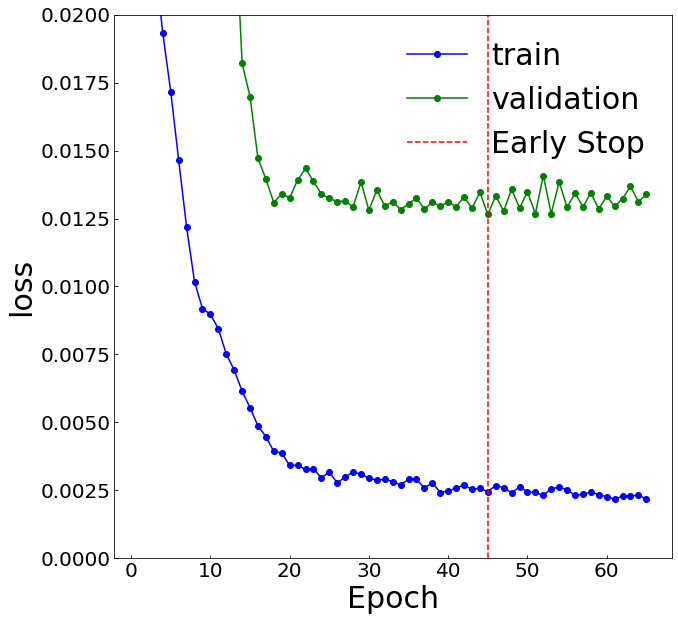

In [65]:
ax = utils.plot_loss(train_loss_list, val_loss_list, epoch)
_ = ax.set_ylim([0, 0.02])

# Testing

Average test finished with 0.92 seconds
Loss: 0.010152
Recurrent test finished with 0.79 seconds
Loss: 0.010152


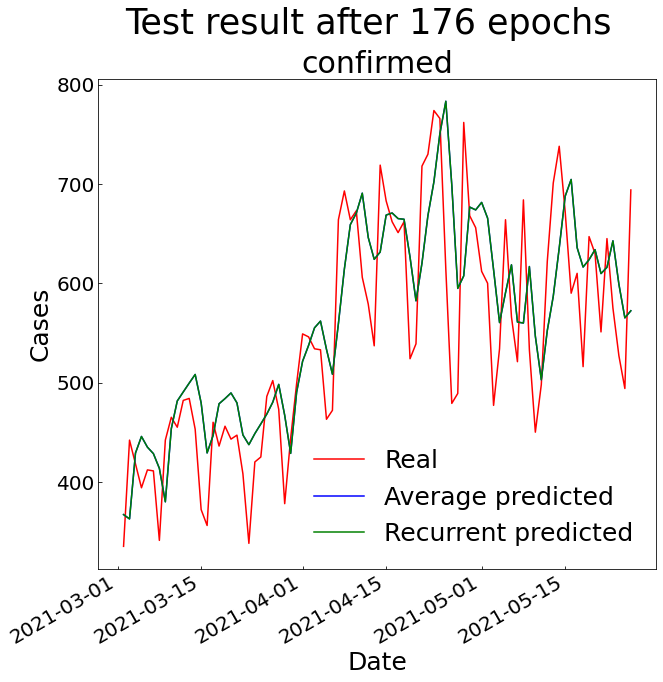

In [50]:
avg_prediction, avg_test_loss = utils.average_test(model, data,
                                                   loss_func=loss_func,
                                                   verbose=True)
recurrent_prediction, recurrent_test_loss = utils.recurrent_test(model, data,
                                                                 loss_func=loss_func,
                                                                 verbose=True)

ax = utils.plot_prediction(data=data,
                           epoch=epoch,
                           #   save_path=os.path.join('fig', PREFIX + "_prediction.png"),
                           avg_prediction=avg_prediction,
                           recurrent_prediction=recurrent_prediction)


# Predict

In [15]:
last_input = data.val_raw[-PAST_DAYS:, data.in_features_idx]
last_input = torch.as_tensor(last_input).unsqueeze(0).to(DEVICE)

model.eval()
with torch.no_grad():
    prediction = model(last_input)
prediction = data.val_output_scaler.inverse_transform(prediction.squeeze(0).cpu().numpy())

print(prediction[:,0])


[620.67523]


# Save the model

In [51]:
#* Save the model with current state
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            'train_loss_list': train_loss_list[:epoch],
            'val_loss_list': val_loss_list[:epoch],
            # 'Remark': 'Training finished',
            'Remark': 'Need more training',
            'test_loss': (avg_test_loss, recurrent_test_loss)},
           os.path.join('model', PREFIX + '_{}.pth'.format(epoch)))

print("Saved model", PREFIX + '_{}.pth'.format(epoch))

Saved model 2021-05-26_biGRU_ccdrntSC2c_PD35_SD1_HS400_DO0.30_OPAdam_LR0.0001_RG0.001_LFSmoothL1Loss_176.pth


# Find best model

In [22]:
best_loss = np.Inf
for file in os.listdir('model'):
    if "_SD{}".format(SUCCESSIVE_DAYS) in file:
        checkpoint = torch.load(os.path.join('model', file))
        test_loss = min(checkpoint['test_loss'][0], checkpoint['test_loss'][1])
        try:
            if test_loss < best_loss:
                best_name = file
                best_loss = test_loss
        except KeyError:
            print("Error: ", file)
print(best_name)
print("loss:", best_loss)

2021-05-26_biGRU_ccdrntSC2c_PD35_SD1_HS400_NL5_DO0.30_OPAdam_LR0.0001_RG0.001_LFSmoothL1Loss_273.pth
loss: 0.009565668817536567
